In [112]:
# Import libraries and dependencies

import geopandas as gpd
import os
import pandas as pd
from pathlib import Path
%matplotlib inline
import hvplot.pandas
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import locale

In [113]:
# Read CSV

stock_data = pd.read_csv(Path('house_data_with_prices.csv'), index_col = 'transaction_date', infer_datetime_format = True, parse_dates = True)

In [114]:
# Count frequency of tickers

stock_data['ticker'].value_counts()

MSFT    141
AAPL     84
NTAP     84
FB       51
NVDA     50
       ... 
TEL       1
SHLS      1
GWRE      1
ROG       1
RP        1
Name: ticker, Length: 149, dtype: int64

In [115]:
# Plot top 5 tickers by year

top_5_tickers = ['MSFT', 'AAPL', 'NTAP', 'FB', 'NVDA']
filtered_ticker_data = stock_data[stock_data['ticker'].isin(top_5_tickers)]

ticker_count_grouped = filtered_ticker_data.groupby(['transaction_year', 'ticker']).size().reset_index(name='count')

bar_chart = ticker_count_grouped.hvplot.bar(
    x='transaction_year',
    y='count',
    by='ticker',
    title='Ticker Counts by Year',
    xlabel='Transaction Year',
    ylabel='Count',
)

bar_chart

:Bars   [transaction_year,ticker]   (count)

In [116]:
# Investigate the jump in NVDA trading activity from 2020 - 2021

In [117]:
# Which representatives were trading NVDA stock in 2021?

NVDA_2021 = stock_data[(stock_data['ticker'] == 'NVDA') & (stock_data['transaction_year'] == 2021)]
representative_count = NVDA_2021['representative'].value_counts().reset_index()
representative_count.columns = ['representative', 'count']
representative_count

,representative,count
0,Michael T. McCaul,8
1,Blake Moore,4
2,Pete Sessions,3
3,Nancy Pelosi,3
4,Josh Gottheimer,2
5,Kathy Manning,2
6,Ro Khanna,2
7,Alan S. Lowenthal,2
8,Kurt Schrader,1
9,David Cheston Rouzer,1


In [118]:
NVDA_2021_reps = representative_count.hvplot.bar(
    x='representative',
    y='count',
    title='NVDA Trades by Representative in 2021',
    xlabel='Representative',
    ylabel='Count',
    width = 1000,
    rot=45,
)
NVDA_2021_reps

:Bars   [representative]   (count)

/Users/mmu8315/anaconda3/envs/dev/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


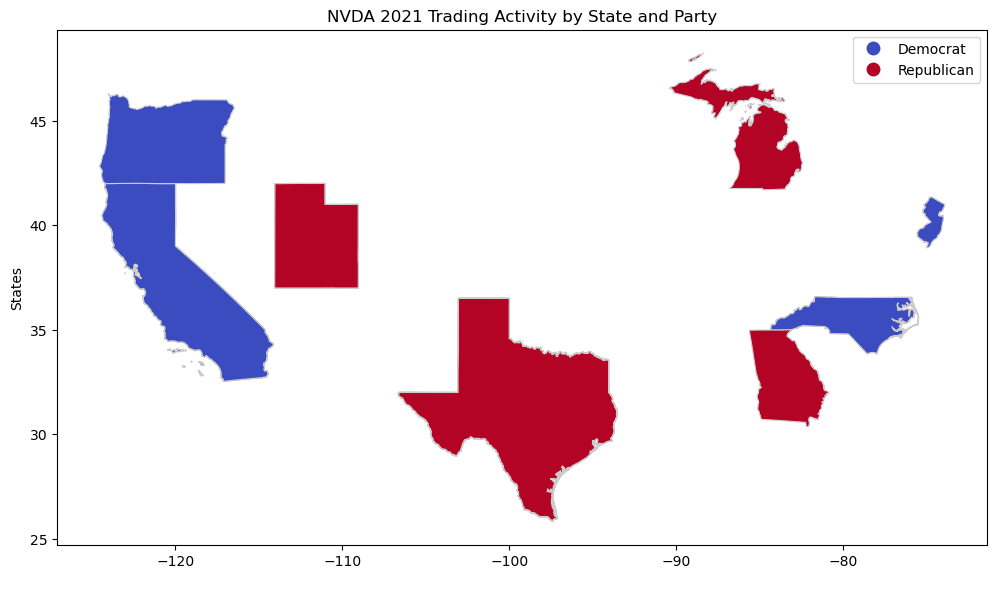

In [119]:
# What states had the most NVDA activity?

# Install geopandas and read state boundary state to plot state

gdf_states = gpd.read_file('us_states.geojson')

merged_df = gdf_states.merge(NVDA_2021, left_on='abbr', right_on='state')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged_df.plot(ax=ax, column='party', legend=True,
               cmap='coolwarm', linewidth=0.8, edgecolor='0.8')

plt.title('NVDA 2021 Trading Activity by State and Party')
plt.xlabel(' ')
plt.ylabel('States')
plt.show()

In [120]:
# See transaction dates & amounts for Michael T. McCaul

mccaul_transactions = NVDA_2021[(NVDA_2021['representative'] == 'Michael T. McCaul')]
mccaul_transactions_table = mccaul_transactions[['amount_high']]
mccaul_transactions_table 

,amount_high
transaction_date,
2021-03-23,50000.0
2021-03-23,50000.0
2021-03-16,100000.0
2021-03-16,100000.0
2021-03-10,50000.0
2021-03-10,50000.0
2021-03-09,50000.0
2021-03-09,50000.0


In [121]:
# Read in NVDA close prices

NVDA_close = pd.read_csv(Path('NVDA_close.csv'), index_col = 'Date', infer_datetime_format = True, parse_dates = True)

In [122]:
# Merge close prices with mccaul_transactions

mccaul_NDVA_close = pd.merge(mccaul_transactions_table, NVDA_close[['Close']], left_index=True, right_index=True, how='inner')
mccaul_NDVA_close

,amount_high,Close
2021-03-09,50000.0,125.20
2021-03-09,50000.0,125.20
2021-03-10,50000.0,124.68
2021-03-10,50000.0,124.68
2021-03-16,100000.0,132.91
2021-03-16,100000.0,132.91
2021-03-23,50000.0,130.71
2021-03-23,50000.0,130.71


In [123]:
# Estimate number of shares 

mccaul_NDVA_close['Estimated Shares Bought'] = mccaul_NDVA_close['amount_high']/mccaul_NDVA_close['Close']
mccaul_NDVA_close

,amount_high,Close,Estimated Shares Bought
2021-03-09,50000.0,125.20,399.361022
2021-03-09,50000.0,125.20,399.361022
2021-03-10,50000.0,124.68,401.026628
2021-03-10,50000.0,124.68,401.026628
2021-03-16,100000.0,132.91,752.388835
2021-03-16,100000.0,132.91,752.388835
2021-03-23,50000.0,130.71,382.526203
2021-03-23,50000.0,130.71,382.526203


In [124]:
# Sum the estimated shares bought

total_mccaul_shares = mccaul_NDVA_close['Estimated Shares Bought'].sum()

print(f"McCaul owns {round(total_mccaul_shares,2)} shares of NVDA.")

McCaul owns 3870.61 shares of NVDA.


In [125]:
# Sum amount_high as cost basis

total_mccaul_cost_basis = mccaul_NDVA_close['amount_high'].sum()

formatted_cost_basis = locale.format_string("%.2f", total_mccaul_cost_basis, grouping=True)

print(f"McCaul's cost basis for NVDA is ${formatted_cost_basis}.")

McCaul's cost basis for NVDA is $500000.00.


In [126]:
# How much are his shares worth today?

NVDA_today = 446.80

NVDA_mccaul_value = total_mccaul_shares * NVDA_today

formatted_NVDA_mccaul_value  = locale.format_string("%.2f", NVDA_mccaul_value, grouping=True)

print(f"McCaul's shares are worth ${formatted_NVDA_mccaul_value} today.")

McCaul's shares are worth $1729386.48 today.


In [127]:
# What is the percent change? 

percent_change = (NVDA_mccaul_value - total_mccaul_cost_basis) / total_mccaul_cost_basis 

formatted_percentage_change = '{:.2%}'.format(percent_change)

print(f"McCaul's shares have appreciated {formatted_percentage_change} since 2021.")

McCaul's shares have appreciated 245.88% since 2021.


In [128]:
# How does this compare to the QQQ as a benchmark of greater market performance? Do congressional members out perform the market in this case?

qqq_price_on_2021_03_09 = stock_data.loc['2021-03-09', 'qqq_price']

print("QQQ Price on 2021-03-09:", qqq_price_on_2021_03_09)

QQQ Price on 2021-03-09: transaction_date
2021-03-09    311.769989
2021-03-09    311.769989
2021-03-09    311.769989
2021-03-09    311.769989
2021-03-09    311.769989
Name: qqq_price, dtype: float64


In [129]:
# How much did qqq appreciate over the same time period?

qqq_today = 375.19

percent_change_qqq = (qqq_today - qqq_price_on_2021_03_09) / qqq_price_on_2021_03_09 *100 
percent_change_qqq

transaction_date
2021-03-09    20.341923
2021-03-09    20.341923
2021-03-09    20.341923
2021-03-09    20.341923
2021-03-09    20.341923
Name: qqq_price, dtype: float64

In [130]:
print(f"The QQQ has appreciated 20.34% in the same period.")

The QQQ has appreciated 20.34% in the same period.


In [131]:
# Which members of congress trade tech stocks the most?

stock_data['representative'].value_counts()

Josh Gottheimer         169
Doug Lamborn             82
Gilbert Cisneros         66
Kevin Hern               61
Susie Lee                52
                       ... 
Mike Garcia               1
Seth Moulton              1
Garret Graves             1
David Cheston Rouzer      1
Mikie Sherrill            1
Name: representative, Length: 72, dtype: int64

In [132]:
# Which stocks does Josh Gottheimer trade most?

# Create data frame 

Josh_Gottheimer_df=stock_data.loc[stock_data.representative=='Josh Gottheimer']
Josh_Gottheimer_df

,transaction_year,ticker,asset_description,type,amount_low,amount_high,amount_avg,representative,district,state,cap_gains_over_200_usd,industry,sector,party,ticker_price,qqq_price
transaction_date,,,,,,,,,,,,,,,,
2022-12-20,2022,ADP,Automatic Data Processing Inc,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,EDP Services,Technology,Democrat,65.05,269.540009
2022-12-06,2022,SHLS,Shoals Technolgies Group - Inc. Class A,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,Semiconductors,Technology,Democrat,24.00,281.679993
2022-11-21,2022,TWKS,Thoughtworks Holding Inc,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,EDP Services,Technology,Democrat,8.34,281.890015
2022-11-14,2022,FLYW,Flywire Corporation - Voting,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,EDP Services,Technology,Democrat,22.47,285.440002
2022-11-02,2022,IBM,International Business Machines Corporation,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,Computer Manufacturing,Technology,Democrat,136.83,265.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-13,2020,MSFT,Microsoft Corporation,purchase,250001,500000.0,375001,Josh Gottheimer,NJ05,NJ,False,Computer Software: Prepackaged Software,Technology,Democrat,183.71,233.970001
2020-02-13,2020,MSFT,Microsoft Corporation,purchase,100001,250000.0,175001,Josh Gottheimer,NJ05,NJ,False,Computer Software: Prepackaged Software,Technology,Democrat,183.71,233.970001
2020-01-29,2020,AAPL,Apple Inc.,purchase,1001,15000.0,8001,Josh Gottheimer,NJ05,NJ,False,Computer Manufacturing,Technology,Democrat,324.34,221.809998


In [133]:
# Look at Josh Gottheimer's top tickers

selected_tickers_JG = ['MSFT', 'AAPL', 'GOOG', 'FB', 'NVDA']

filtered_df_JG = Josh_Gottheimer_df[Josh_Gottheimer_df['ticker'].isin(selected_tickers_JG)]

ticker_value_counts_JG = filtered_df_JG['ticker'].value_counts().reset_index()
ticker_value_counts_JG.columns = ['ticker', 'Count']
ticker_value_counts_JG



,ticker,Count
0,MSFT,59
1,AAPL,14
2,GOOG,10
3,NVDA,5
4,FB,3


In [134]:
# Plot top traded stocks for Josh Gottheimer

bar_chart_JG = ticker_value_counts_JG.hvplot.bar(x='ticker', y='Count', title='Josh Gottheimer Trades')
bar_chart_JG

:Bars   [ticker]   (Count)

/var/folders/bl/c2t095fj3z36430_ckzjs_r80000gn/T/ipykernel_37910/2963635476.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stock_data.groupby(['party']).sum().plot(kind='pie',y='transaction_year',autopct='%1.0f%%')


<Axes: ylabel='transaction_year'>

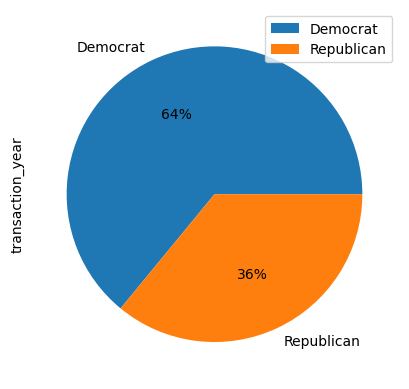

In [135]:
# Do republicans or democrats trade tech stocks most? 

stock_data.groupby(['party']).sum().plot(kind='pie',y='transaction_year',autopct='%1.0f%%')


In [136]:
# What was the trading activity for the 5 top congressional traders

rep_tech_df=stock_data.loc[stock_data.party=='Republican']
rep_tech_df

dem_tech_df=stock_data.loc[stock_data.party=='Democrat']
dem_tech_df

Josh_Gottheimer_df=stock_data.loc[stock_data.representative=='Josh Gottheimer']
Josh_Gottheimer_df

Doug_Lamborn_df=stock_data.loc[stock_data.representative=='Doug Lamborn']
Doug_Lamborn_df

Gilbert_Cisneros_df=stock_data.loc[stock_data.representative=='Gilbert Cisneros']
Gilbert_Cisneros_df

Susie_Lee_df=stock_data.loc[stock_data.representative=='Susie Lee']
Susie_Lee_df

Donald_S_Beyer_Jr_df=stock_data.loc[stock_data.representative=='Donald S. Beyer, Jr.']
Donald_S_Beyer_Jr_df

,transaction_year,ticker,asset_description,type,amount_low,amount_high,amount_avg,representative,district,state,cap_gains_over_200_usd,industry,sector,party,ticker_price,qqq_price
transaction_date,,,,,,,,,,,,,,,,
2021-09-20,2021,CDNS,Cadence Design Systems Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Computer Software: Prepackaged Software,Technology,Democrat,160.93,365.700012
2021-08-18,2021,CDNS,Cadence Design Systems Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Computer Software: Prepackaged Software,Technology,Democrat,148.02,362.209991
2021-08-05,2021,CDNS,Cadence Design Systems Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Computer Software: Prepackaged Software,Technology,Democrat,151.76,369.670013
2021-06-24,2021,GOOG,Alphabet Inc - Class C Capital Stock,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,"Computer Software: Programming, Data Processing",Technology,Democrat,253.70,349.890015
2021-06-17,2021,ASML,ASML Holding N.V. - New York Registry Shares,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Industrial Machinery/Components,Technology,Democrat,81.47,345.339996
2021-03-18,2021,KAI,Kadant Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Industrial Machinery/Components,Technology,Democrat,178.00,312.040009
2021-03-11,2021,KAI,Kadant Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Industrial Machinery/Components,Technology,Democrat,451.06,318.040009
2021-03-03,2021,CDNS,Cadence Design Systems Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Computer Software: Prepackaged Software,Technology,Democrat,133.74,309.160004
2021-02-04,2021,KAI,Kadant Inc,purchase,1001,15000.0,8001,"Donald S. Beyer, Jr.",VA08,VA,False,Industrial Machinery/Components,Technology,Democrat,2062.37,330.239990


In [137]:
#Plot trades

pd.concat([Josh_Gottheimer_df,Doug_Lamborn_df,Gilbert_Cisneros_df,Susie_Lee_df,Donald_S_Beyer_Jr_df],axis=0).groupby(['transaction_year','party']).size().reset_index(name='count').hvplot.bar(
    x='party',
    y='count',
    by='transaction_year',
    title='Party trades last three years',
    xlabel='Party',
    ylabel='trades')

:Bars   [party,transaction_year]   (count)